### 1-bit Reversible Feynman Gate
This notebook implements a 1-bit Reversible Feynman Gate with CBLB blocks.

#### Setting up the imports
External libraries + our own models and parameters

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import lib.models as models
from lib.parameters import *

#### Comparator model
Building our comparator model

In [5]:
def reversible_feynman_gate(T, state, *params):
    # Read the state
    L_A, L_B, L_I1, L_I2, L_I3, L_I4, L_I5, L_I6, a, b, I1, I2, I3, I4, I5, I6 = state
    # Read the params
    delta_L, gamma_A, gamma_B, n_a, n_b, theta_A, theta_B, eta_a, eta_b, omega_a, omega_b, m_a, m_b, delta_a, delta_b, rho_a, rho_b = params
    # Set params to use later
    params_or = delta_L, gamma_A, n_b, theta_A, eta_a, omega_a, m_a, delta_a, rho_a
    params_neg = delta_L, gamma_A, n_b, theta_A, eta_a, omega_a, m_a, delta_a, rho_a
    params_yes = gamma_A, n_b, theta_A, delta_a, rho_a

    ### P = 1

    # Prepare state for yes
    state_yes = I1, a
    dI1 = models.yes_cell_wrapper(state_yes, params_yes)

    ### XOR

    # not_yes_or
    # Prepare state
    state_not_yes_or = L_I2, b, a, I2
    dL_I2, dI2 = models.yes_not_or(state_not_yes_or, params_or)

    # neg
    # Prepare state
    state_neg = L_I3, I3, I2
    dL_I3, dI3 = models.not_cell_wrapper(state_neg, params_neg)

    # yes_not_or
    # Prepare state
    state_or = L_I4, a, b, I4
    dL_I4, dI4 = models.yes_not_or(state_or, params_or)

    # neg
    # Prepare state
    state_neg = L_I5, I5, I4
    dL_I5, dI5 = models.not_cell_wrapper(state_neg, params_neg)

    # yes_yes_or
    # Prepare state
    state_yes_yes_or = I3, I5, I6
    dI6 = models.yes_yes_or(state_yes_yes_or, params_or)

    # Set changes of unused variables to 0
    dL_A, dL_B, dL_I1, dL_I6, da, db = 0, 0, 0, 0, 0, 0

    # We are finished
    return np.array([dL_A, dL_B, dL_I1, dL_I2, dL_I3, dL_I4, dL_I5, dL_I6, da, db, dI1, dI2, dI3, dI4, dI5, dI6])

### Parameters
Setting the parameters

In [6]:
params = [delta_L,
          gamma_A,
          gamma_A,
          n_a,
          n_a,
          theta_A,
          theta_A,
          eta_a,
          eta_a,
          omega_a,
          omega_a,
          m_a,
          m_a,
          delta_a,
          delta_a,
          0,
          0]


### Testing the model
Running the simulation + Plotting the results

In [7]:
import seaborn as sns
sns.set_theme(style="darkgrid")

Iteration:  A: 0  B: 0
Iteration:  A: 0  B: 1
Iteration:  A: 1  B: 0
Iteration:  A: 1  B: 1


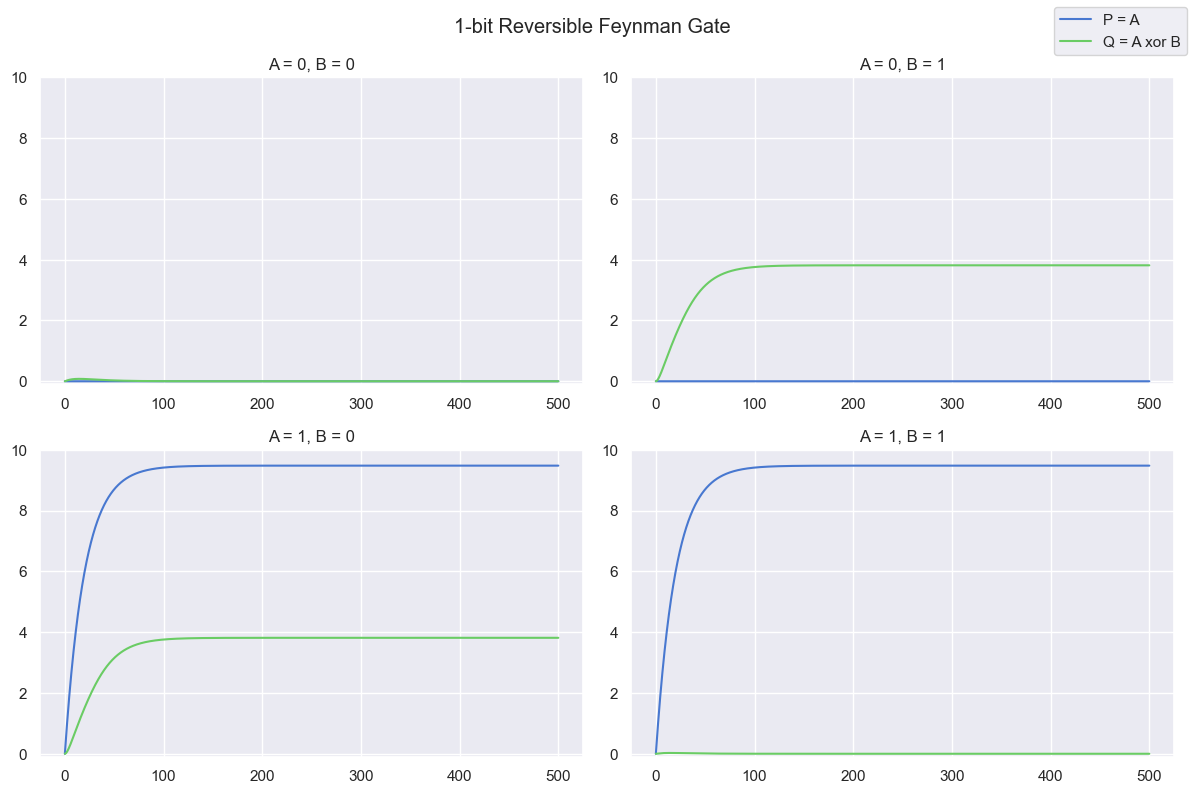

In [13]:
t_end = 500
N = t_end * 10
T = np.linspace(0, t_end, N)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
iteration_a = -1
iteration_b = 0
for A in range(2):
    iteration_a += 1
    iteration_b = 0
    for B in range(2):
        print("Iteration: ", "A:", A, " B:", B)
        Y0 = np.zeros(16)
        Y0[8] = A
        Y0[9] = B
        sol = solve_ivp(reversible_feynman_gate, [0, t_end], Y0, args=params, dense_output=True)
        z = sol.sol(T)
        # Value of A = B
        p = z.T[:, 10]
        q = z.T[:, 15]
        #ax.plot(T, value_a, color="red", label="A")
        #ax.plot(T, value_b, color="blue", label="B")
        # ax.set_ylim(bottom=0, top=1)
        ax[iteration_a, iteration_b].set_ylim(bottom=-0.1, top=10)
        if iteration_a == 0 and iteration_b == 0:
            ax[iteration_a, iteration_b].plot(T, p, color=sns.color_palette("muted")[0], label="P = A")
            ax[iteration_a, iteration_b].plot(T, q, color=sns.color_palette("muted")[2], label="Q = A xor B")
        else: 
            ax[iteration_a, iteration_b].plot(T, p, color=sns.color_palette("muted")[0])
            ax[iteration_a, iteration_b].plot(T, q, color=sns.color_palette("muted")[2])
        title = "A = {a_bit}, B = {b_bit}".format(a_bit = A, b_bit = B)
        ax[iteration_a, iteration_b].set_title(title)
        iteration_b += 1
filename = "slike/1_bit_reversible_feynman_gate/png/reversible_feynman_gate_simulation"
fig.suptitle("1-bit Reversible Feynman Gate")
fig.legend()
fig.tight_layout()
fig.savefig(filename)